# Monte Carlo Simulation of Redcare Pharmacy Stock prices
## Data Acquisition and Preprocessing
* I first load the neccessary python packages `numpy matplotlib seaborn pandas yfinance datetime`

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta
import os

* Secondly, I write functions that fetch the Redcare pharmacy stock data **RDC.DE** and at the same time save the raw data under `data/raw/`

In [7]:
def fetch_stock_data(ticker, start_date, end_date, output_dir="."):
    """Fetch historical stock data from Yahoo Finance."""
    stock = yf.Ticker(ticker)
    data = stock.history(start=start_date, end=end_date)
    data.to_csv(f"{output_dir}/{ticker}_data_{start_date}_{end_date}.csv", header=True, index=True)
    return data

data = fetch_stock_data("RDC.DE", "2020-01-01", "2024-12-31", output_dir="../data/raw")

In [8]:
def calculate_log_returns(data):
    """Calculate log returns of the closing prices."""
    data['Log Return'] = np.log(data['Close'] / data['Close'].shift(1))
    data.dropna(inplace=True)
    return data
data = calculate_log_returns(data)

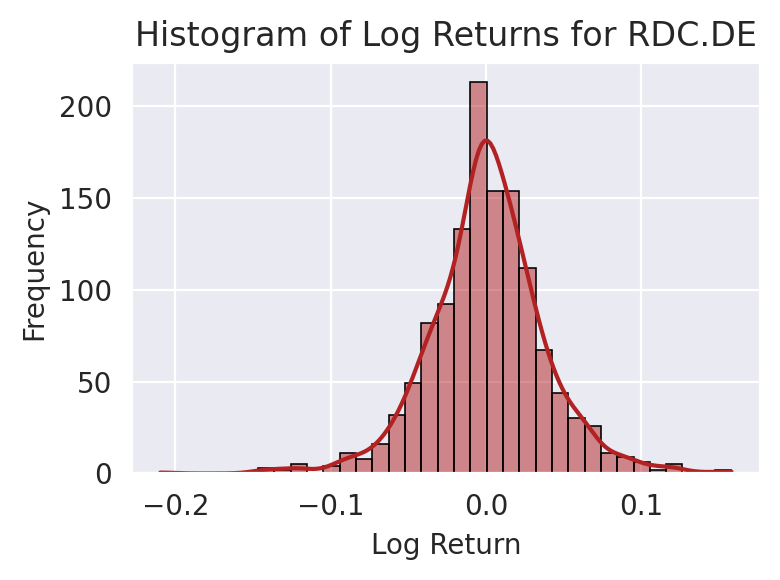

In [9]:
def plot_log_return_histogram(data, output_dir: str | None = None):
    """Plot histogram of log returns."""
    plt.figure(dpi=200, figsize=(4, 3), tight_layout=True)
    sns.set_style('darkgrid')
    sns.histplot(x=data['Log Return'], bins=35, kde=True, color='firebrick', stat='count', edgecolor='black', )
    plt.title('Histogram of Log Returns for RDC.DE')
    plt.xlabel('Log Return')
    plt.ylabel('Frequency')
    if output_dir:
        os.makedirs(output_dir, exist_ok=True)
        plt.savefig(os.path.join(output_dir, 'RDC_DE_log_return_histogram.png'))
    plt.show()
plot_log_return_histogram(data)

In [50]:
def compute_statistics(data: pd.DataFrame, output_dir: str | None = None) -> pd.DataFrame:
    """Compute basic statistics of log returns."""
    daily_mean = data['Log Return'].mean()
    daily_volatility = data['Log Return'].std()
    annualized_return = daily_mean * 252
    annualized_volatility = daily_volatility * np.sqrt(252)
    stats_df = pd.DataFrame({
        'Daily Mean': [daily_mean],
        'Annualized Return': [annualized_return],
        'Daily Volatility': [daily_volatility],
        'Annualized Volatility': [annualized_volatility]
    })
    if output_dir:
        os.makedirs(output_dir, exist_ok=True)
        stats_df.to_csv(os.path.join(output_dir, 'RDC_DE_log_return_statistics.csv'), index=False, header=True)
    return stats_df
stats = compute_statistics(data, output_dir="../results/tables")
print(stats)

   Daily Mean  Annualized Return  Daily Volatility  Annualized Volatility
0   -0.000942          -0.237467          0.035733               0.567242
